In [11]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [12]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [13]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [14]:
#Load AIRI data 
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
#This file's calendar isn't recognized when using xr.open_dataset. The above workaround is from: 
#https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
# "M" means "month end frequency" (see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

In [15]:
airi_dat

<xarray.Dataset>
Dimensions:  (time: 1752)
Coordinates:
  * time     (time) datetime64[ns] 1871-02-01 1871-03-01 ... 2017-01-01
Data variables:
    precip   (time) float32 ...
Attributes:
    title:        
    description:  All-India Rainfall
    scripturl01:  https://climexp.knmi.nl/getindices.cgi?STATION=All-India_Ra...
    comment:      
    institution:  KNMI Climate Explorer
    scripturl02:  https://climexp.knmi.nl/dat2nc.cgi?id=$id&station=All-India...
    history:       2020-04-02  2:43:20 bin/dat2nc data/pALLIN.dat p All-India...
    Conventions:  CF-1.0

In [16]:
precip = airi_dat['precip']

In [17]:
#Load SST data
dataset_url = "http://apdrc.soest.hawaii.edu/dods/public_data/NOAA_SST/ERSST/monthly_v5"
sst_dat = xr.open_dataset(dataset_url)
sst = sst_dat['sst']

In [18]:
#Slice SST data to the same duration as precip and calculate monthly anomalies
sst_subset = sst.sel(time=slice('1871-01-30','2017-01-01'))
sst_clim = sst_subset.groupby('time.month').mean('time')
sst_anom = sst_subset.groupby("time.month")-sst_clim
sst_anom

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'sst' (time: 1752, lat: 89, lon: 180)>
array([[[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [1.788139e-06, 1.788139e-06, ..., 1.788139e-06, 1.788139e-06],
        [1.788139e-06, 1.788139e-06, ..., 1.788139e-06, 1.788139e-06]],

       [[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [1.788139e-06, 1.788139e-06, ..., 1.788139e-06, 1.788139e-06],
        [1.788139e-06, 1.788139e-06, ..., 1.788139e-06, 1.788139e-06]],

       ...,

       [[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [2.433813e-02, 1.393175e-02, ..., 9.700537e-03, 2.214563e-02],
        [2.947164e-02, 2.386618e-02, ..., 2.060997e-02, 2.932453e-02]],

       [[         nan,          n

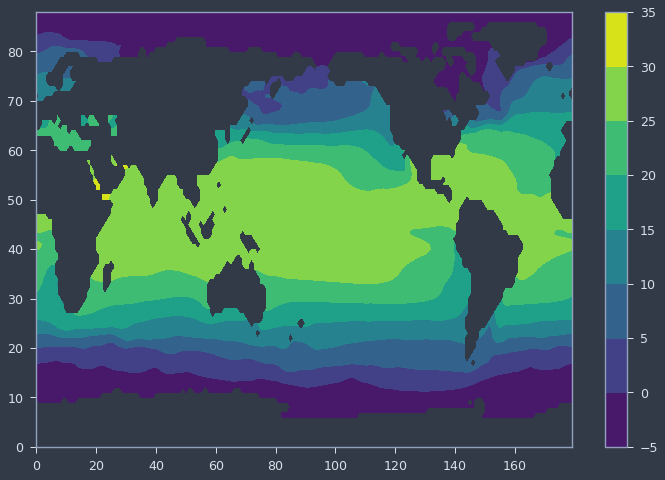

In [19]:
#Test plot of sst_clim
from matplotlib import pyplot
plt.contourf(sst_clim.sel(month=6))
plt.colorbar()

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


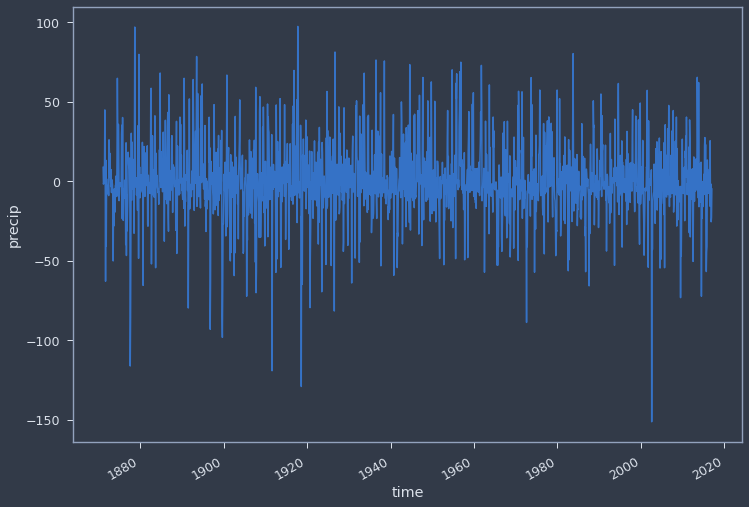

In [20]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anom = precip.groupby("time.month") - precip_clim
precip_anom.plot()

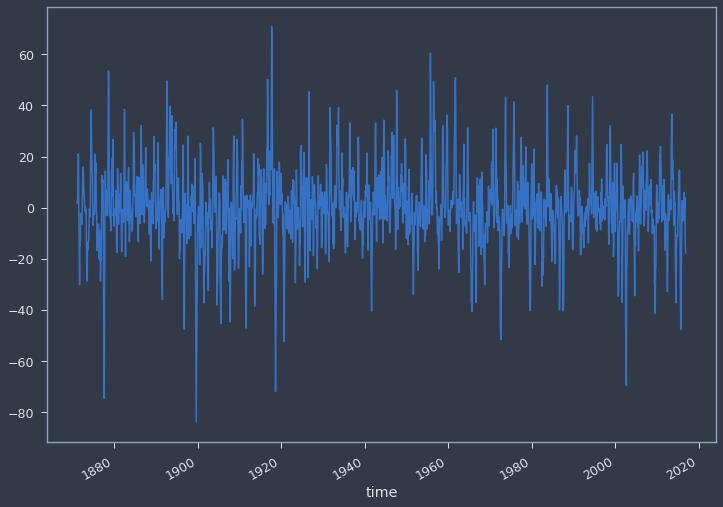

In [21]:
#Seasonal means of precip anomalies
precipa_seasonal = precip_anom.rolling(time=3,center=True).mean()
precipa_seasonal
precipa_seasonal.plot()

In [22]:
#Seasonal means of SSTA
ssta_seasonal = sst_anom.rolling(time=3,center=True).mean()
ssta_seasonal

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray (time: 1752, lat: 89, lon: 180)>
array([[[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan]],

       [[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [1.788139e-06, 1.788139e-06, ..., 1.788139e-06, 1.788139e-06],
        [1.788139e-06, 1.788139e-06, ..., 1.788139e-06, 1.788139e-06]],

       ...,

       [[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [1.193027e-01, 1.360739e-01, ..., 7.475201e-02, 9.859761e-02],
        [1.231529e-01, 1.254364e-01, ..., 1.021582e-01, 1.181607e-01]],

       [[         nan,          nan, ..

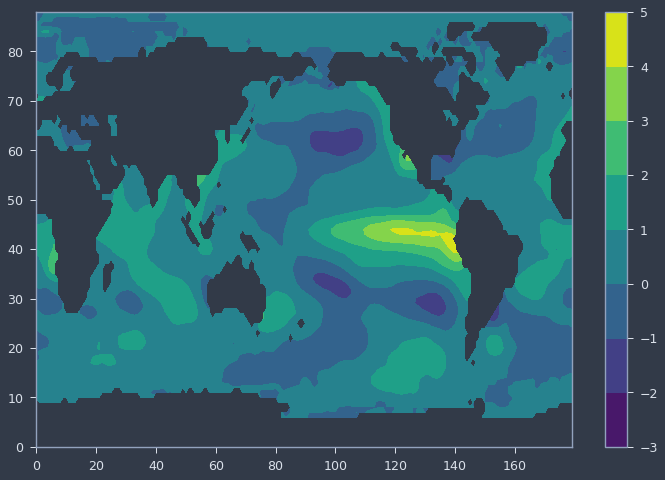

In [23]:
#Test plot of seasonal SST anomalies in DJF 1997-8
plt.contourf(ssta_seasonal.sel(time='1998-01-01'))
plt.colorbar()

In [24]:
#There is no inbuilt xarray correlation function so I used Ryan Abernathey's functions from:
#https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
#NANs will RUIN EVERYTHING. Drop all leading/trailing NaNs after making a seasonal mean.
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# correlation starts here

In [26]:
#First, try correlation map with no lag. This should give us r ~= -0.5 in the Tropical Pacific.
x = ssta_seasonal[1:-1,:,:]
y = precipa_seasonal[1:-1]
sst_r = correlation(x, y, dims='time')
#y = ssta_seasonal.sel(lat=0,lon=270)[1:-1]
#dims = 'time'

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0.5, 1.0, 'Contemporaneous Correlation Between SST and AIRI Anomalies (3-month running mean)')

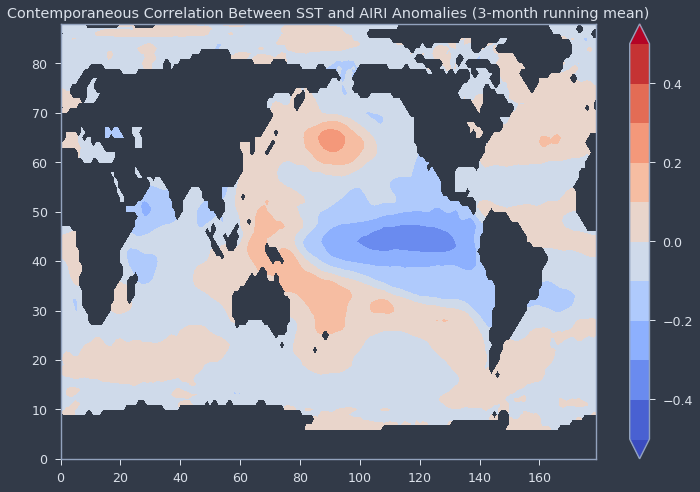

In [27]:
#Plot the result
lev = np.linspace(-.5, .5, 11, endpoint=True)
plt.contourf(sst_r,lev,cmap='coolwarm',extend='both')
plt.colorbar()
plt.title('Contemporaneous Correlation Between SST and AIRI Anomalies (3-month running mean)')

In [28]:
#Try the same with only JJA:
julys=np.arange(6,1752,12)
ssta_jja = ssta_seasonal[julys,:,:]
precipa_jja = precipa_seasonal[julys]
sst_jja_r = correlation(ssta_jja,precipa_jja,dims='time')

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0.5, 1.0, 'Contemporaneous Correlation Between SST and AIRI Anomalies (JJA Mean)')

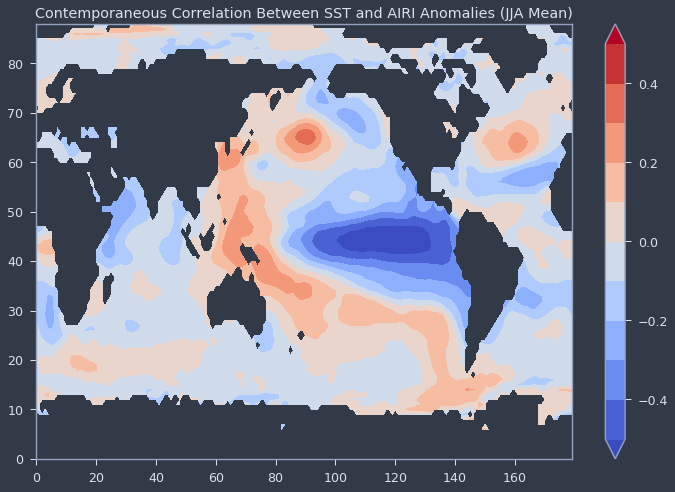

In [29]:
#Plot JJA correlation
lev = np.linspace(-.5, .5, 11, endpoint=True)
plt.contourf(sst_jja_r,lev,cmap='coolwarm',extend='both')
plt.colorbar()
plt.title('Contemporaneous Correlation Between SST and AIRI Anomalies (JJA Mean)')

In [30]:
#Try this with a lag of 3 months
ssta_seasonal_3shift = ssta_seasonal.shift(time=-3)
ssta_mam = ssta_seasonal_3shift[julys,:,:]

Text(0.5, 1.0, 'Green: Shifted SSTA (by 3 months)')

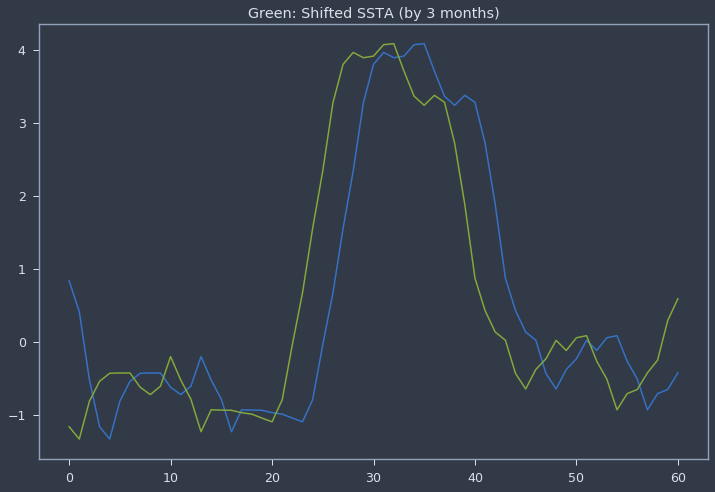

In [31]:
plt.plot(ssta_seasonal.sel(lon=270,lat=0,time=slice('1995-01-01','2000-01-01')))
plt.plot(ssta_seasonal_3shift.sel(lon=270,lat=0,time=slice('1995-01-01','2000-01-01')))
plt.title('Green: Shifted SSTA (by 3 months)')

In [32]:
#Run correlation
sst_mam_r = correlation(ssta_mam,precipa_jja,dims='time')

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0.5, 1.0, 'Correlation Between MAM SST and JJA AIRI Anomalies')

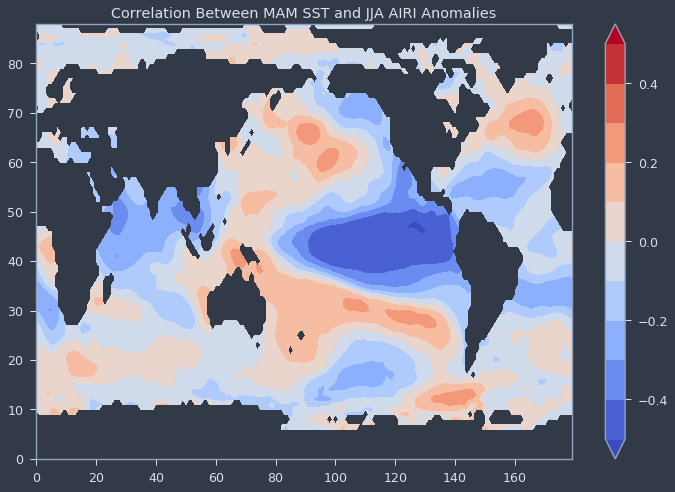

In [33]:
#Plot MAM/JJA correlation
lev = np.linspace(-.5, .5, 11, endpoint=True)
plt.contourf(sst_mam_r,lev,cmap='coolwarm',extend='both')
plt.colorbar()
plt.title('Correlation Between MAM SST and JJA AIRI Anomalies')

In [34]:
#Try May-March tendency and jjas AIRI to be more consistent with Wang paper
ssta_2shift_dt = sst_anom-sst_anom.shift(time=2) #This has the May minus March value at the May index
precipa_4seasonal = precip_anom.rolling(time=4).mean() #This has the JJAS mean at the Sep index
septembers = np.arange(8,1752,12)
precipa_jjas = precipa_4seasonal[septembers]
ssta_2shift_dt_sep = ssta_2shift_dt.shift(time=4)[septembers,:,:]

In [35]:
sst_may_mar_r = correlation(ssta_2shift_dt_sep,precipa_jjas,dims='time')

/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0.5, 1.0, 'Correlation Between May-March SSTA and JJAS AIRI Anomalies')

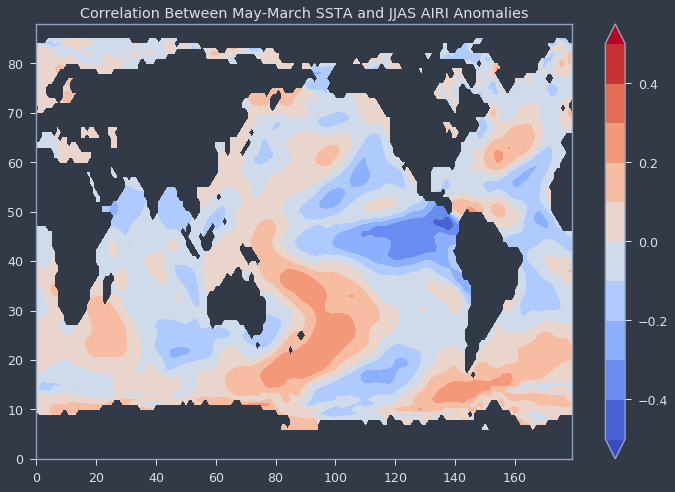

In [36]:
#Plot correlation
lev = np.linspace(-.5, .5, 11, endpoint=True)
plt.contourf(sst_may_mar_r,lev,cmap='coolwarm',extend='both')
plt.colorbar()
plt.title('Correlation Between May-March SSTA and JJAS AIRI Anomalies')

# moist static energy

In [41]:
# Load data
mse_dat1 = xr.open_dataset('data/ERA_Interim_MSE950.nc',decode_times=False)
#The original ferret coordinate names are non-standard so need to be renamed
mse_dat = mse_dat1.rename({'G4_LON_2': 'longitude','G4_LAT_1': 'latitude','LV_ISBL035_35':'level','MONTHAX':'time'})
#Calendar needs to be reformatted to be recognized by xarray (it doesn't recognize gregorian calendars?)
units, reference_date = mse_dat.time.attrs['units'].split('since')
mse_dat['time'] = pd.date_range(start=reference_date, periods=mse_dat.sizes['time'], freq='MS')
mse_dat

<xarray.Dataset>
Dimensions:               (MONTH_GREGORIAN: 12, bnds: 2, latitude: 256, level: 1, longitude: 512, time: 456)
Coordinates:
  * longitude             (longitude) float32 0.0 0.70312524 ... 359.297
  * latitude              (latitude) float32 -89.46282 -88.76695 ... 89.46282
  * level                 (level) int32 950
  * MONTH_GREGORIAN       (MONTH_GREGORIAN) float64 15.5 45.12 ... 319.2 349.7
  * time                  (time) datetime64[ns] 1979-01-01 ... 2016-12-01
Dimensions without coordinates: bnds
Data variables:
    G4_LON_2_bnds         (longitude, bnds) float32 ...
    G4_LAT_1_bnds         (latitude, bnds) float32 ...
    LV_ISBL035_35_bnds    (level, bnds) int32 ...
    MONTH_GREGORIAN_bnds  (MONTH_GREGORIAN, bnds) float64 ...
    MSE_CLIM              (MONTH_GREGORIAN, level, latitude, longitude) float64 ...
    MONTHAX_bnds          (time, bnds) float64 ...
    MSE_ANOM              (time, level, latitude, longitude) float64 ...
Attributes:
    history:     

In [42]:
mse_anom = mse_dat['MSE_ANOM'].squeeze(drop=True) #Drop levels dimension (the file only has values for 950 hPa)
mse_anom

<xarray.DataArray 'MSE_ANOM' (time: 456, latitude: 256, longitude: 512)>
[59768832 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 0.70312524 ... 358.59387 359.297
  * latitude   (latitude) float32 -89.46282 -88.76695 ... 88.76695 89.46282
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2016-12-01
Attributes:
    long_name:               MSE-MSE_CLIM[GT=MSE@ASN]
    climatology_time_range:  JAN-1979:DEC-2016

In [43]:
#Make 3-month running mean to get seasonal means
#Seasonal means of SSTA
msea_seasonal = mse_anom.rolling(time=3,center=True).mean()
msea_seasonal

<xarray.DataArray (time: 456, latitude: 256, longitude: 512)>
array([[[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan]],

       [[  410.278053,   411.105577, ...,   407.703885,   408.543136],
        [  240.85753 ,   241.1407  , ...,   236.692466,   238.6718  ],
        ...,
        [-1765.666123, -1771.304713, ..., -1753.179569, -1759.044701],
        [-1539.164874, -1540.392023, ..., -1534.504288, -1537.047305]],

       ...,

       [[ 1407.892302,  1408.523667, ...,  1405.599915,  1406.424548],
        [ 1395.229767,  1396.97553 , ...,  1389.975284,  1392.255409],
        ...,
        [ 6566.277464,  6571.070489, ...,  6555.64742 ,  6561.098837],
        [ 6403.70355 ,  6405.267443, ...,  6399.4579  ,  6401.5326  ]],

       [[         nan,      

In [44]:
#Use subset of AIRI and calculate correlation
x = msea_seasonal[1:-1,:,:] #remove leading and trailing NaNs
y = precipa_seasonal.sel(time=slice(x.time[1],x.time[-1]))
mse_r = correlation(x,y,dims='time')

ValueError: indexes along dimension 'time' are not equal

In [ ]:
#Plot the result
from cartopy import config
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
plt.contourf(mse_r.longitude,mse_r.latitude,mse_r,lev,cmap='coolwarm',extend='both',transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar()
plt.title('Contemporaneous Correlation Between MSE and AIRI Anomalies (3-month running mean)')
plt.show()

In [ ]:
# Copyright (c) 2020 Medha Palavalli.